# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add LAVD folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/LAVD")

Wall time: 0 ns


# Overview

In the following notebook we evaluate the Poincarea map on the time-periodic version of the Bickley jet [Bickley jet](http://localhost:8888/notebooks/TBarrier/2D/data/Bickley/Bickley.ipynb). Eventhough the Bickley jet is analytically well defined, the velocity field has been [discretized](http://localhost:8888/notebooks/TBarrier/2D/data/Bickley/Bickley.ipynb) over a gridded spatio-temporal domain. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Poincare Map:

    * Compute trajectories launched from a regular meshgrid over [0,1000$ \mathrm{T_{periodic}} $], where $ \mathrm{T_{periodic}}$ is the periodic period which is given in [Bickley](http://localhost:8888/notebooks/TBarrier/2D/data/Bickley/Bickley.ipynb).
    
    <br />
    
    * Sample the trajectories at a regular time-intervals $ \mathrm{T_{periodic}}$.


# Import data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Bickley/Bickley.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 133 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 4

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = True
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = 2*(X[0,1]-X[0,0])
dy_data = 2*(Y[1,0]-Y[0,0])

delta = [dx_data, dy_data]

# periodic period
T_periodic = time_data[0,-1]-time_data[0,0]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = T_periodic

# periodic time-interval
N_periodic = 200
time = np.linspace(t0, tN, N_periodic)

time_append = time.copy()

N_periodic_intervals = 1000
for i in range(N_periodic_intervals):
    
    time = np.append(time, time[-1]+time_append[1:])

time_poincare = time[::(N_periodic-1)]
# length of time interval (in days)
lenT = tN-t0

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 20000
ymin = -3000
ymax = 3000

# spacing of meshgrid (in degrees)
dx = 2*(X[0,1]-X[0,0])
dy = 2*(Y[1,0]-Y[0,0])

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 144 ms


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V)

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

Wall time: 223 ms


# Compute trajectories

Here we compute trajectories launched from a rectangular meshgrid over the time-interval [0, 1000$ \mathrm{T_{periodic}} $]

In [6]:
%%time
# Import package for computing trajectories/velocity
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for parallel computing
from joblib import Parallel, delayed

# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# split x0, y0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

def parallel_Fmap(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
    
    # Compute trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0] # shape (N, 2, Nx*Ny)

    return Fmap

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_Fmap)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

Fmap = results[0]

for res in results[1:]:
    Fmap = np.append(Fmap, res, axis = 2)

Wall time: 7min 27s


# Poincare map

The Poincare map of the time-periodic Bickley-jet is constructed by stroboscopically sampling the trajectories at regular periodic time-intervals $ \mathrm{T_{periodic}} $. The trajectories are initially seeded over a rectangular meshgrid and advected over a period of $ [0, 1000T_{periodic}] $. Sampling the resulting trajectories at regular intervals $ \mathrm{T_{periodic}} $ leads to discretized trajectories. The poincare map requires a fairly small number of particles, but a very long time-interval compared to other existing LCS diagnostics in order to converge. We only retain the last 500 intersections of the trajectories with the (time-)slice given by $ \mathrm{t} \ \mathrm{mod} \ \mathrm{T_{periodic}} $.

In [7]:
# reshape to gridded domain
Fmap = Fmap.reshape((Fmap.shape[0], 2, X_domain.shape[0], X_domain.shape[1]))

# only keep last 500 intersections
N_poincare_samples = 500 

# discretize trajectories (=flow map)
Fmap_poincare = Fmap[::(N_periodic-1),:,:,:]
Fmap_poincare = Fmap_poincare[-N_poincare_samples:,:,:,:]

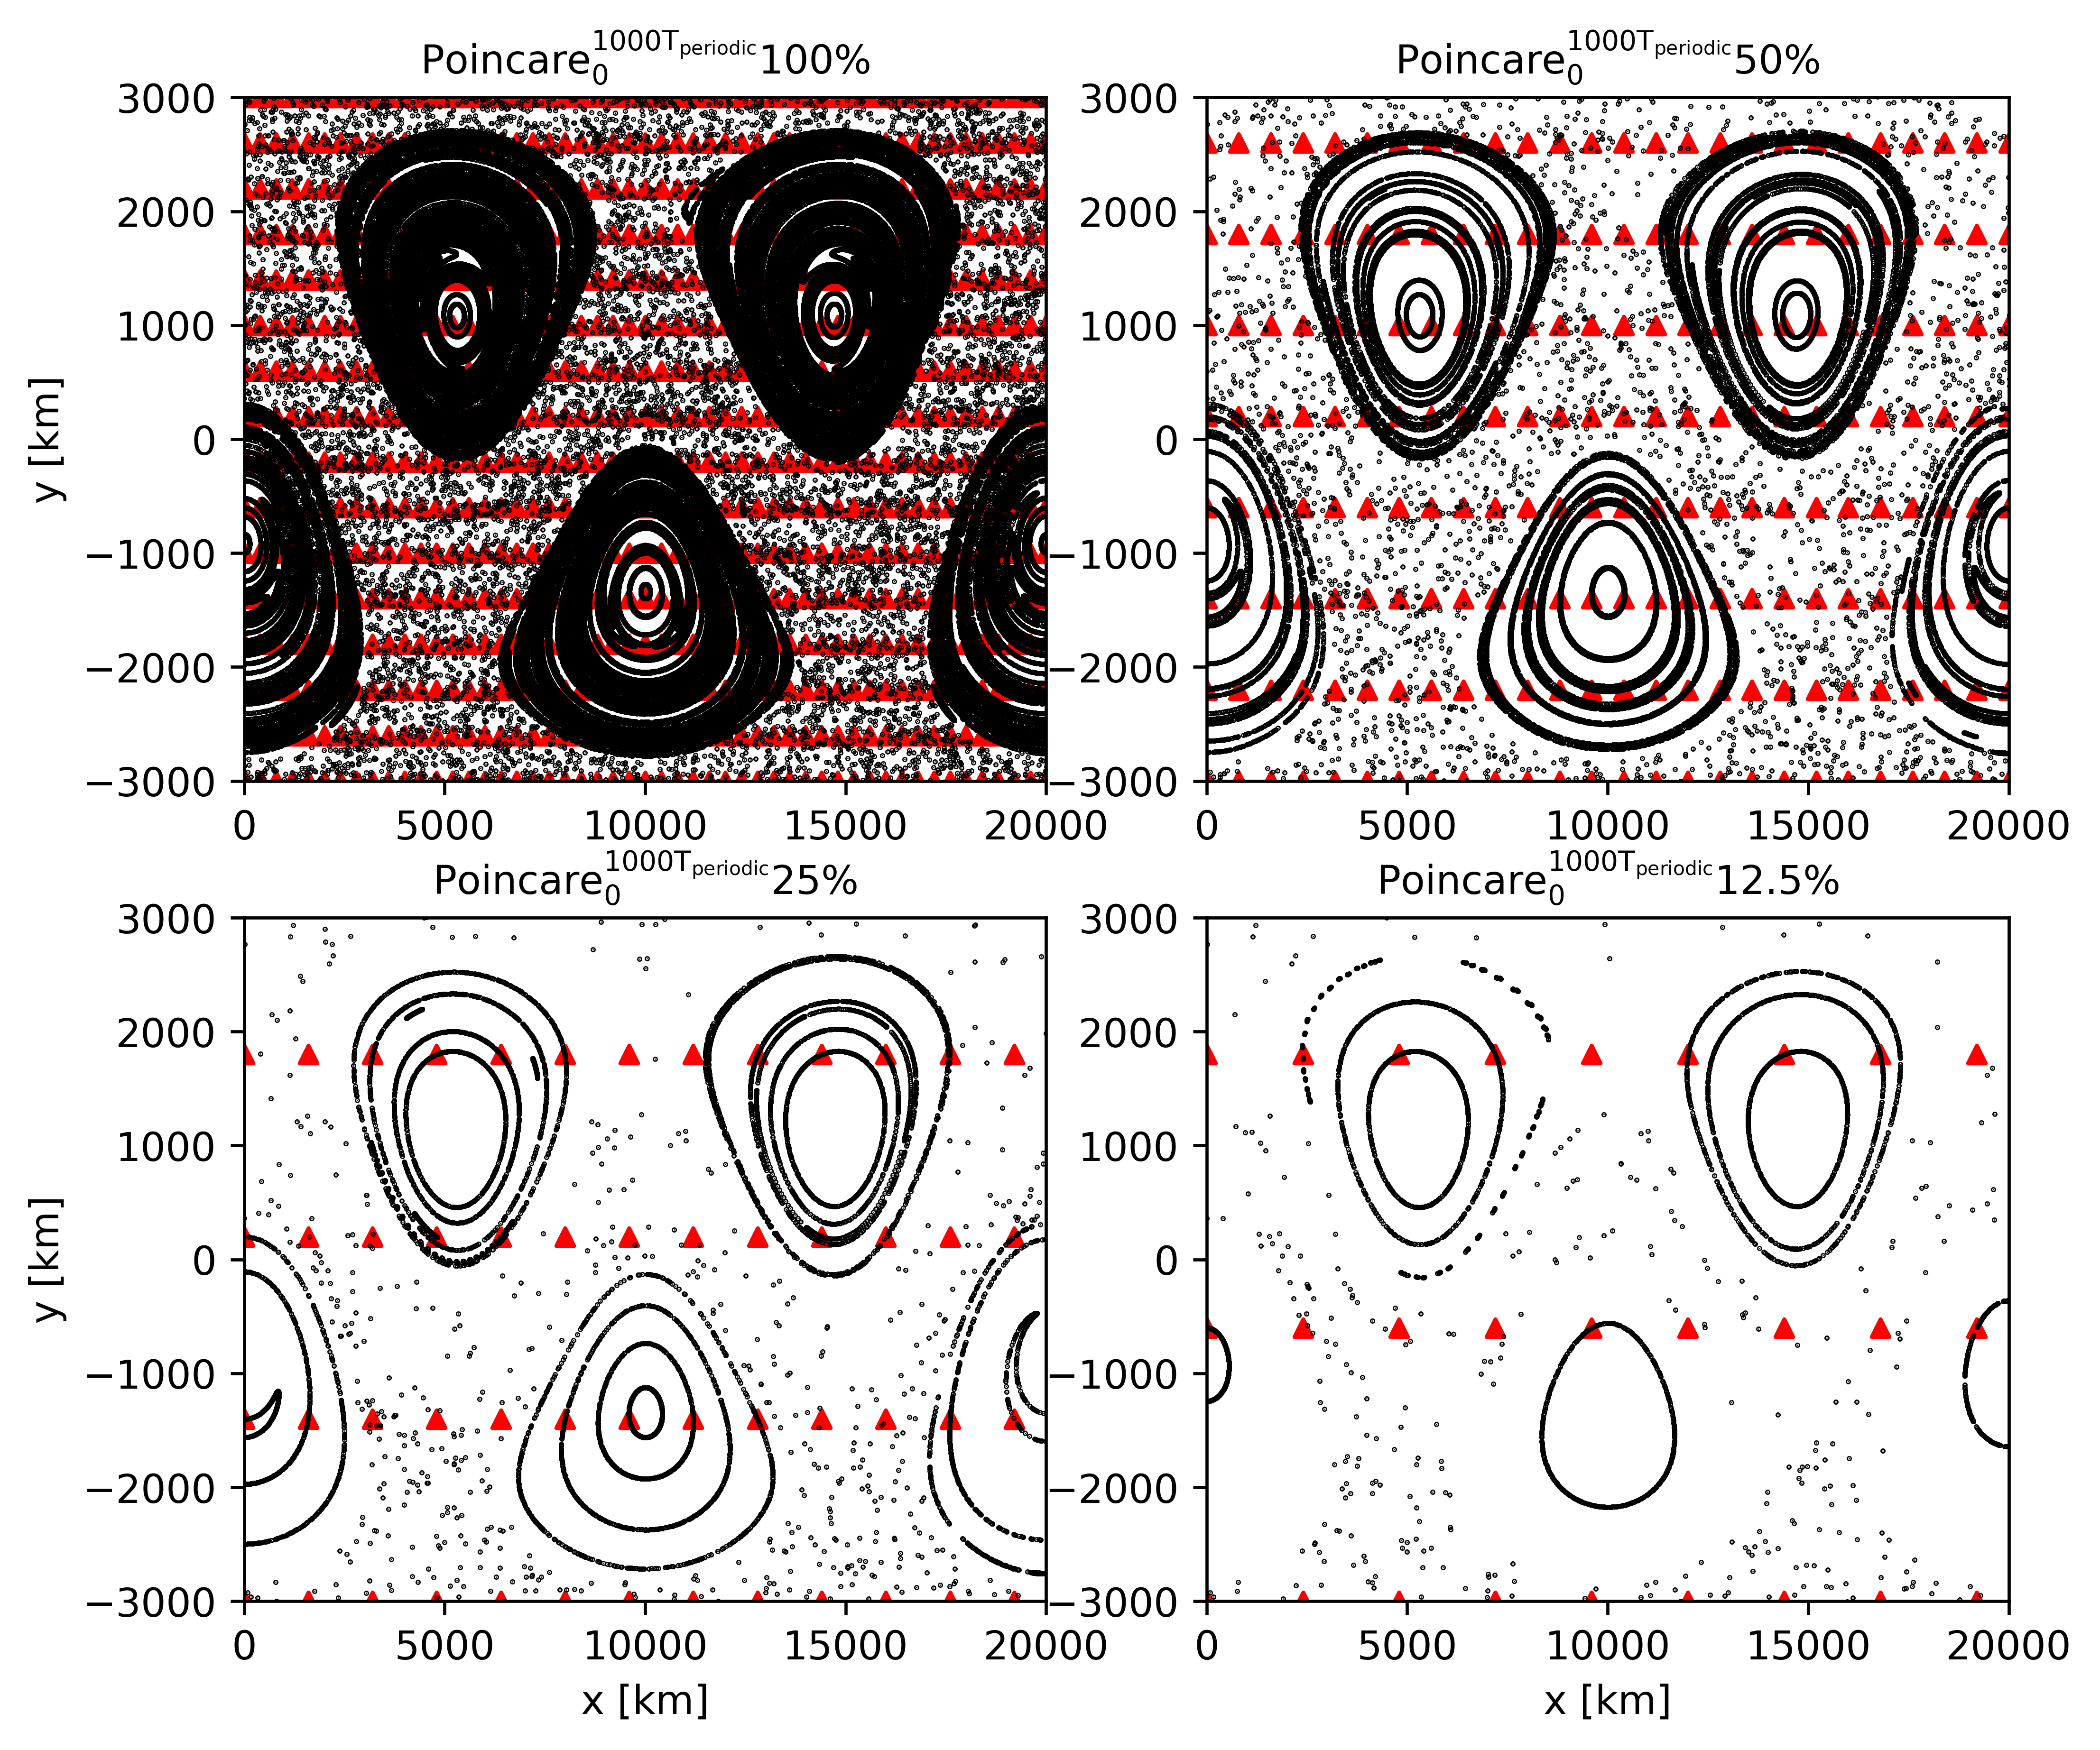

In [14]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(8, 7))

cax = ax0.scatter(Fmap[0, 0, :, :], Fmap[0, 1, :, :], s = 20, c = "r", marker = "^")
cax = ax0.scatter(Fmap_poincare[:, 0, :, :], Fmap_poincare[:, 1, :, :], s = 0.1, c = "k")

cax = ax1.scatter(Fmap[0, 0, ::2, ::2], Fmap[0, 1, ::2, ::2], s = 20, c = "r", marker = "^")
cax = ax1.scatter(Fmap_poincare[:, 0, ::2, ::2], Fmap_poincare[:, 1, ::2, ::2], s = 0.1, c = "k")

cax = ax2.scatter(Fmap[0, 0, ::4, ::4], Fmap[0, 1, ::4, ::4], s = 20, c = "r", marker = "^")
cax = ax2.scatter(Fmap_poincare[:, 0, ::4, ::4], Fmap_poincare[:, 1, ::4, ::4], s = 0.1, c = "k")

cax = ax3.scatter(Fmap[0, 0, ::6, ::6], Fmap[0, 1, ::6, ::6], s = 20, c = "r", marker = "^")
cax = ax3.scatter(Fmap_poincare[:, 0, ::6, ::6], Fmap_poincare[:, 1, ::6, ::6], s = 0.1, c = "k")

# Axis Labels
ax2.set_ylabel("y [km]", fontsize = 10)
ax2.set_xlabel("x [km]", fontsize = 10)
ax3.set_xlabel("x [km]", fontsize = 10)
ax0.set_ylabel("y [km]", fontsize = 10)

ax0.set_title(r'$ \mathrm{Poincare}_{0}^{1000\mathrm{T_{periodic}}} 100$%', fontsize = 10)
ax1.set_title(r'$ \mathrm{Poincare}_{0}^{1000\mathrm{T_{periodic}}} 50$%', fontsize = 10)
ax2.set_title(r'$ \mathrm{Poincare}_{0}^{1000\mathrm{T_{periodic}}} 25$%', fontsize = 10)
ax3.set_title(r'$ \mathrm{Poincare}_{0}^{1000\mathrm{T_{periodic}}} 12.5$%', fontsize = 10)

ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymin, ymax])
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymin, ymax])

plt.show()

The cloud of black dots indicates the discretized trajectories sampled at regular periodic time-intervals ($ \mathrm{T}_{periodic} $), The red triangles denote the initial position of the trajectories. Smooth curves indicate non-chaotic trajectories. The closed tori remain visible even under progressive downsampling.

# References

[1] Rypina, I. I., Brown, M. G., Beron-Vera, F. J., Koçak, H., Olascoaga, M. J., & Udovydchenkov, I. A. (2007). On the Lagrangian dynamics of atmospheric zonal jets and the permeability of the stratospheric polar vortex. Journal of the Atmospheric Sciences, 64(10), 3595-3610.

[2] del‐Castillo‐Negrete, D., & Morrison, P. J. (1993). Chaotic transport by Rossby waves in shear flow. Physics of Fluids A: Fluid Dynamics, 5(4), 948-965.